In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from cataclop.ml import preprocessing
from cataclop.ml import exploration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

from cataclop.ml.pipeline import factories

In [2]:
program = factories.Program.factory('default', version='1.1')

In [3]:
program.predict(dataset_params = {
    'from': '2018-07-01',
    'to': '2018-12-31',
    'categories': ['ATTELE']
}, model_params = {
    'kfolds': 3,
    'nan_flag': 100000,
    'n_targets': 2
})

preparing model data
preparing stacked model data


In [4]:
len(program.df)

9333

In [5]:
df = program.df

In [6]:
def bet(df, features, categorical_features, targets, N=1, max_odds=20, break_on_bet=True, break_on_odds=False):

    races = df.sort_values('start_at').groupby('race_id')

    bets = []

    for (id, race) in races:

        candidate_bets = []

        nums = []

        for target in targets:

            r = race.sort_values(by=target, ascending=False)

            if len(r) <= N:
                break
                
            NN = N

            for n in range(NN):

                player = r.iloc[n]

                odds = player['final_odds_ref']

                if max_odds is not None and odds > max_odds:
                    if break_on_odds:
                        break
                    else:
                        continue

                nth = (r['final_odds_ref']<odds).sum()+1
                
                #bet = np.clip(np.abs(player[target])/100.0, 0, 10)
                
                #bet = np.round(1+bet) * 1.5
                
                #if bet <= 0:
                #    break
                
                if n+1 < len(r) and r.iloc[n+1][target] == player[target]:
                    NN = NN+1
                    
                bet = 1

                profit = player['winner_dividend']/100.0 * bet - bet
                profit_placed = player['placed_dividend']/100.0 * bet - bet

                row = [id, player['start_at'], player['num'], player['position'], n, odds, player['final_odds'], target, player[target], r[target].std(), bet, profit, profit_placed]

                for nn in range(1,4):
                    if n+nn < len(r):
                        row.append(r.iloc[n+nn][target])
                    else:
                        row.append(np.nan)

                for f in features:
                    row.append(player[f])
                for f in categorical_features:
                    row.append(player[f])

                candidate_bets.append( row )

                nums.append(player['num'])

                if break_on_bet:
                    break

        #if len(candidate_bets) == 1:
        #    bets += candidate_bets
        bets += candidate_bets

    cols = ['id', 'date', 'num', 'pos', 'nb', 'odds_ref', 'odds_final', 'target', 'pred', 'pred_std', 'bet', 'profit', 'profit_placed']

    for nn in range(1,4):
        cols.append('next_pred_{}'.format(nn))

    cols = cols + features + categorical_features

    bets = pd.DataFrame(bets, columns=cols)
    bets['date'] = pd.to_datetime(bets['date'])

    bets = bets.set_index(bets['date'])
    bets = bets.sort_index()

    bets['bets'] = bets['bet'].cumsum()
    bets['stash'] = bets['profit'].cumsum()

    return bets



In [7]:
#exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(pos+1) for pos in range(1,8)] + ['pred_xgb_100_1', 'pred_rf_100_1', 'pred_knn_5_1', 'pred_mlp_100_1', 'pred_ridge_1_1']).sort_values(by='pred_stacked_8', ascending=False)
exploration.random_race(df, cols=['position', 'declared_player_count', 'sub_category', 'num', 'final_odds', 'final_odds_ref', 'target_pos'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]).sort_values(by='position', ascending=True)



position  declared_player_count              sub_category  num  \
race_id                                                                       
22068   457       1.0                      8  INTERNATIONALE_AUTOSTART    8   
        451       2.0                      8  INTERNATIONALE_AUTOSTART    2   
        456       3.0                      8  INTERNATIONALE_AUTOSTART    7   
        453       4.0                      8  INTERNATIONALE_AUTOSTART    4   
        452       5.0                      8  INTERNATIONALE_AUTOSTART    3   
        455       6.0                      8  INTERNATIONALE_AUTOSTART    6   
        450       7.0                      8  INTERNATIONALE_AUTOSTART    1   
        454       NaN                      8  INTERNATIONALE_AUTOSTART    5   

             final_odds  final_odds_ref  target_pos  pred_xgb_10_1  \
race_id                                                              
22068   457         1.7             1.4         1.0       0.085275   
        451        12.8             9.3         2.0       0.073339   
        456         5.1             6.6         2.0       0.086168   
        453        70.0            43.6         2.0       0.070980   
        452        20.5            22.4         2.0       0.071326   
        455        60.3            28.0         2.0       0.073871   
        450         9.8            20.9         2.0       0.071326   
        454         8.1            23.0         2.0       0.071954   

             pred_xgb_30_1  pred_xgb_100_1  pred_knn_1_1  pred_knn_2_1  \
race_id                                                                  
22068   457       0.055950        0.070067      0.000000      0.000000   
        451       0.024728        0.022473      0.000000      0.000000   
        456       0.068201        0.093212      0.000000      0.000000   
        453       0.021312        0.008053      0.000000      0.000000   
        452       0.021938        0.010349      0.000000      0.000000   
        455       0.030286        0.013441      0.333333      0.166667   
        450       0.020426        0.008439      0.000000      0.000000   
        454       0.026781        0.016078      0.000000      0.000000   

             pred_knn_3_1  pred_knn_4_1  pred_knn_5_1  pred_knn_6_1  \
race_id                                                               
22068   457      0.000000      0.083333      0.066667      0.055556   
        451      0.000000      0.000000      0.000000      0.000000   
        456      0.000000      0.000000      0.000000      0.000000   
        453      0.000000      0.000000      0.000000      0.000000   
        452      0.000000      0.083333      0.066667      0.055556   
        455      0.111111      0.083333      0.066667      0.055556   
        450      0.000000      0.000000      0.000000      0.000000   
        454      0.000000      0.000000      0.000000      0.000000   

             pred_knn_7_1  pred_knn_8_1  pred_knn_9_1  pred_knn_10_1  \
race_id                                                                
22068   457      0.047619      0.041667      0.037037       0.033333   
        451      0.000000      0.041667      0.037037       0.033333   
        456      0.000000      0.000000      0.037037       0.033333   
        453      0.047619      0.041667      0.037037       0.033333   
        452      0.047619      0.041667      0.037037       0.033333   
        455      0.047619      0.041667      0.037037       0.033333   
        450      0.000000      0.000000      0.000000       0.000000   
        454      0.000000      0.000000      0.037037       0.033333   

             pred_stacked_mlp_sigmoid_1  pred_stacked_mlp_relu_1  
race_id                                                           
22068   457                    1.278292                 6.864530  
        451                    1.278292                 6.673937  
        456                    1.278292                 6.835357  
        453  

In [24]:
df = program.df
df['pred_rnd'] = np.random.rand(df.shape[0])
df['pred_sum'] = df[['pred_{}_1'.format(model['name']) for model in program.model.models ]].sum(axis=1)

'''
for model in program.model.models:
    df['pred_{}_1_3'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(1,4) ] ].sum(axis=1)
    df['pred_{}_2_4'.format(model['name'])] = df[ ['pred_{}_{}'.format(model['name'], i) for i in range(2,5) ] ].sum(axis=1)
'''

'''
for model in program.model.models:
    df['pred_minus_ref_{}'.format(model['name'])] = df['pred_{}_1'.format(model['name'])] - df['final_odds_ref']
    
for model in program.model.stacked_models:
    df['pred_minus_ref_stacked_{}'.format(model['name'])] = df['pred_stacked_{}_1'.format(model['name'])] - df['final_odds_ref']
'''


bets = bet(df, program.model.features, program.model.categorical_features, 
    N=6, max_odds=None, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_{}'.format(model['name'], i+1) for i in range(program.model.params['n_targets']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models] 
   )

'''
bets = bet(df, program.model.features, program.model.categorical_features, 
    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, 
    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]
   )
'''
    
    

"\nbets = bet(df, program.model.features, program.model.categorical_features, \n    N=3, max_odds=30, break_on_bet=False, break_on_odds=False, \n    targets=['pred_rnd', 'final_odds_ref', 'pred_sum'] + ['pred_{}_1'.format(model['name']) for model in program.model.models] + ['pred_stacked_{}_1'.format(model['name']) for model in program.model.stacked_models]\n   )\n"

In [9]:
program.df.race_id.nunique()

757

In [10]:
def graph_bb(bb, f):
    results = []

    for s in bb[f].value_counts().index:
        results = []
        x = bb[ (bb[f] == s) & (bb['pred_std'] != 0) & (bb['pred'] != 0) ].copy()
        if len(x) == 0:
            continue
        #print("---\n{}\t{:+.2f}\t{:+.2f}\t{:+.2f}\n---".format(s, x['profit'].sum(), x['bet'].sum(), len(x)))

        fig, axs = plt.subplots(1,1)

        for t in x['target'].value_counts().index:
            bbb = x[(x['target'] == t)].copy()
            #bbb = bbb[ (bbb['pred']>bbb['pred'].quantile(0.85)) ].copy()


            results.append({
                'idx_1': s,
                'idx_2': t,
                'profit': bbb.profit.sum(),
                'profit_place': bbb.profit_placed.sum(),
                'bet': bbb.bet.sum(),
                'bets': bbb.bet.count(),
                'avg': bbb.profit.sum() / bbb.bet.sum()
            })

            '''
            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            fig, axs = plt.subplots(1,1)
            bbb['stash'].plot(figsize=(6, 2))
            bbb['cbet'].plot(figsize=(6, 2))
            plt.show()
            '''

            #print("{:10s}: \t {:+.2f} \t {:+.0f} \t {:+.2f}".format(t, bbb.profit.sum(), bbb.profit.count(), bbb.profit.mean()) )

            bbb['stash'] = bbb['profit'].cumsum()
            bbb['cbet'] = bbb['bet'].cumsum()

            bbb['stash'].plot(figsize=(10, 2))
            bbb['cbet'].plot(figsize=(10, 2))

        results = pd.DataFrame(results)
        results = results.set_index(['idx_1', 'idx_2'])
        print(results.sort_values(by='avg', ascending=False))


        plt.show()    

    
    

In [11]:
#countries = list(bets['country'].value_counts()[0:10].index)
#sub_categories = list(bets['sub_category'].value_counts()[0:10].index)

#%store countries
#%store sub_categories

In [35]:
%store -r params
%store -r countries
%store -r sub_categories

In [38]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args

target = 'pred_xgb_100_1'

c_min = bets[(bets['target'] == target)]['pred'].min()
c_mean = bets[(bets['target'] == target)]['pred'].mean()
c_max = bets[(bets['target'] == target)]['pred'].max()

space = [
          Real(1, 10, name='min_odds'),
          Real(10, 60, name='max_odds'),
          Real(c_min, c_mean, name='min_pred'),
          Real(c_mean, c_max, name='max_pred'),
          Integer(5, 25, name='max_players')] + [
          Integer(0,1, name='country_{}'.format(country)) for country in countries] + [
          Integer(0,1, name='sub_category_{}'.format(sub_category)) for sub_category in sub_categories] + [
          Integer(0,1, name='nb_{}'.format(n)) for n in range(0,6)]
         
def x_to_params(x):
    params = {}
    
    params['min_odds'] = x[0]
    params['max_odds'] = x[1]
    params['max_pred'] = x[3]
    params['min_pred'] = x[2]
    params['max_players'] = x[4]
    
    for i, country in enumerate(countries):
        params['country_{}'.format(country)] = x[5+i]
        
    for i, sc in enumerate(sub_categories):
        params['sub_category_{}'.format(sc)] = x[5+len(countries)+i]
        
    for n in range(0,6):
        params['nb_{}'.format(n)] = x[5+len(countries)+len(sub_categories)+n]

    return params

@use_named_args(space)
def f(**params):
    return ff(params)
    
def ff(params, train=True):
    
    print(params)
    
    b = bets[ (bets['pred'] != 0) & (bets['target']==target) & (bets['pred_std'] != 0)]
    
    b = b[ (b['odds_ref'] > params['min_odds']) & (b['odds_ref'] < params['max_odds']) & (b['declared_player_count'] > 1) & (b['declared_player_count'] <= params['max_players']) ]
    
    b = b[(b['pred'] > params['min_pred']) & (b['pred'] < params['max_pred'])]
    
    for country in countries:
        if params['country_{}'.format(country)] == 0:
            b = b[ b['country'] != country ]
            
    for sub_category in sub_categories:
        if params['sub_category_{}'.format(sub_category)] == 0:
            b = b[ b['sub_category'] != sub_category ]
            
    for n in range(0,6):
        if params['nb_{}'.format(n)] == 0:
            b = b[ b['nb'] != n]
    
    p = b.profit.sum()
    pp = len(b[b['profit'] > 0])
    bet = b.bet.sum()
    
    print("{:+.2f} {:+.2f}\n".format(p, bet))
        
    if bet == 0:
        return 0
    
    if not train:
        return b
    
    return - (p)
    
    

In [14]:
#from skopt import dummy_minimize, gp_minimize, gbrt_minimize

#res = gbrt_minimize(f, space, n_calls=100)

In [15]:
#print(res.x, res.fun)

In [16]:
#params = x_to_params(res.x)
#%store params

In [17]:
len(program.model.models[0]['estimators'])
program.model.hash

'288e902a9cd69b8d95b9c3904340fb19'

In [39]:
bb = ff(params, False)

{'min_odds': 9.275110298140955, 'max_odds': 45.28784664998953, 'max_pred': 0.6323368951546166, 'min_pred': 0.038645641963681795, 'max_players': 14, 'country_FRA': 1, 'country_ESP': 1, 'country_NLD': 0, 'country_AUT': 0, 'country_CHE': 1, 'country_BEL': 1, 'country_AUS': 1, 'country_IRL': 0, 'country_SWE': 1, 'country_NOR': 0, 'sub_category_AUTOSTART': 1, 'nb_0': 0, 'nb_1': 1, 'nb_2': 0, 'nb_3': 0, 'nb_4': 1, 'nb_5': 0}
-40.60 +102.00



                                        avg  bet  bets  profit  profit_place
idx_1     idx_2                                                             
AUTOSTART pred_stacked_mlp_relu_1  0.627273   77    77    48.3          12.0


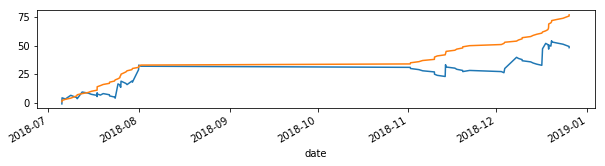

                                                       avg  bet  bets  profit  \
idx_1                    idx_2                                                  
INTERNATIONALE_AUTOSTART pred_stacked_mlp_relu_1 -0.853846   13    13   -11.1   

                                                  profit_place  
idx_1                    idx_2                                  
INTERNATIONALE_AUTOSTART pred_stacked_mlp_relu_1           1.9  


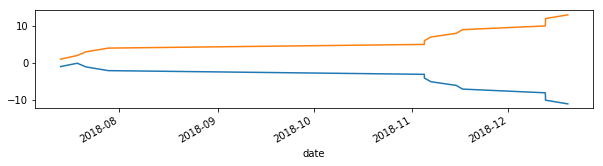

                                                   avg  bet  bets  profit  \
idx_1                idx_2                                                  
EUROPEENNE_AUTOSTART pred_stacked_mlp_relu_1  2.033333    6     6    12.2   

                                              profit_place  
idx_1                idx_2                                  
EUROPEENNE_AUTOSTART pred_stacked_mlp_relu_1           1.0  


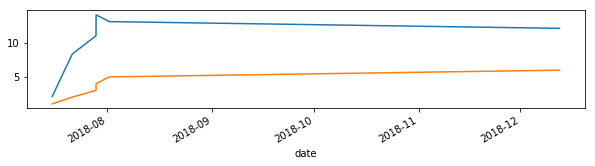

                                              avg  bet  bets  profit  \
idx_1               idx_2                                              
NATIONALE_AUTOSTART pred_stacked_mlp_relu_1 -0.24    5     5    -1.2   

                                             profit_place  
idx_1               idx_2                                  
NATIONALE_AUTOSTART pred_stacked_mlp_relu_1          -3.8  


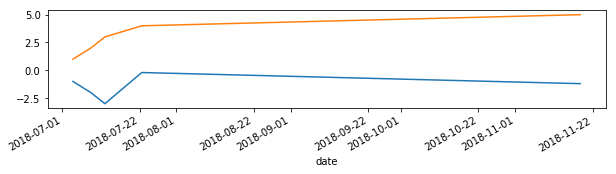

                                                            avg  bet  bets  \
idx_1                            idx_2                                       
APPRENTIS_LADS_JOCKEYS_AUTOSTART pred_stacked_mlp_relu_1  1.375    4     4   

                                                          profit  profit_place  
idx_1                            idx_2                                          
APPRENTIS_LADS_JOCKEYS_AUTOSTART pred_stacked_mlp_relu_1     5.5           1.8  


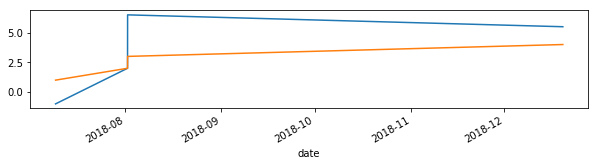

                                            avg  bet  bets  profit  \
idx_1              idx_2                                             
AMATEURS_AUTOSTART pred_stacked_mlp_relu_1 -0.1    4     4    -0.4   

                                            profit_place  
idx_1              idx_2                                  
AMATEURS_AUTOSTART pred_stacked_mlp_relu_1          -2.7  


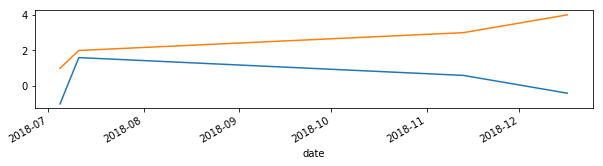

                                              avg  bet  bets  profit  \
idx_1                idx_2                                             
A_RECLAMER_AUTOSTART pred_stacked_mlp_relu_1 -1.0    3     3    -3.0   

                                              profit_place  
idx_1                idx_2                                  
A_RECLAMER_AUTOSTART pred_stacked_mlp_relu_1          -3.0  


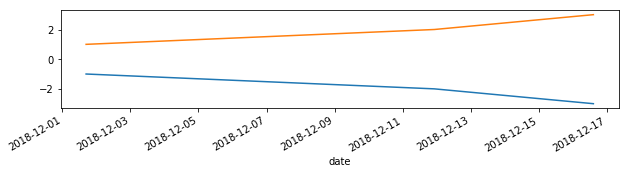

                                    avg  bet  bets  profit  profit_place
idx_1      idx_2                                                        
GROUPE_III pred_stacked_mlp_relu_1 -1.0    1     1    -1.0           0.7


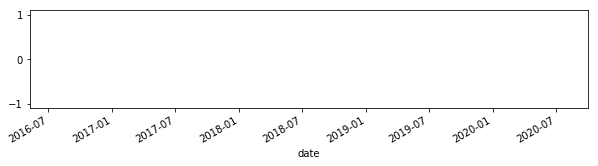

In [120]:
bb = bets[ ((bets['nb']==2) ) & (bets['target']=='pred_stacked_mlp_relu_1') & (bets['odds_ref']<8) & (bets['odds_ref']>3) & (bets['pred']<=1)]
#bb = bets[ ((bets['nb']==2) ) & (bets['target']!='fpred_knn_2_1') & (bets['odds_ref']<10) & (bets['odds_ref']>3) & (bets['pred']>0.1)]
#bb = bets[ (bets['country']!='dFRA') & (bets['sub_category']!='dNATIONALE_AUTOSTART') & (bets['nb']==1) & (bets['target']!='kpred_knn_1_1') & (bets['pred']>0.) & (bets['odds_ref']<10) & (bets['odds_ref']>1)  ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & (bets['odds_ref']>=bets['odds_1']) & (bets['odds_ref']<20) & (bets['target']!='psred_mlp_20_1') ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']=='AUTOSTART') & (bets['nb']<=0) & (bets['odds_ref']>=0) & (bets['odds_ref']<20) ].copy()
#bb = bets[ (bets['country']=='FRA') & (bets['sub_category']!='COURSE_A_CONDITIONS') & (bets['nb']==0) & ( (bets['target']=='pred_knn_10_1') | (bets['target']=='pred_minus_ref_lasso_1') ) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>20)].copy()        
#bb = bets[ (bets['country']=='FRA') & (bets['nb']==0) & (bets['odds_ref']>10) & (bets['odds_ref']<20) & (bets['pred']>0)].copy()
#bb = bb.groupby('id').filter(lambda r: r['num'].count() == 2)
#graph_bb( bets[(bets['target']=='pred_lasso_0.1_1') & (bets['nb']==0) & (bets['odds_ref']>5) & (bets['odds_ref']<20) & (bets['pred']>0.)], 'sub_category')
#bb['profit'] = bb['profit'] * 1/(1+bb['nb'])
#bb['bet'] = bb['bet'] * 1/(1+bb['nb'])

#bb['profit'] = bb['profit'] * np.round(bb['pred']*100)
#bb['bet'] = bb['bet'] * np.round(bb['pred']*100)

graph_bb(bb, 'sub_category')




In [20]:
len(df[ (df['position']==1)  ])

705

In [21]:
df['placed_3_count'].describe()

count    9333.000000
mean        1.987892
std         2.910982
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max        29.000000
Name: placed_3_count, dtype: float64

In [22]:
bb

,id,date,num,pos,nb,odds_ref,odds_final,target,pred,pred_std,bet,profit,profit_placed,next_pred_1,next_pred_2,next_pred_3,declared_player_count,handicap_distance,handicap_distance_amax,handicap_distance_amin,handicap_distance_mean,handicap_distance_r,handicap_distance_std,handicap_weight,handicap_weight_amax,handicap_weight_amin,handicap_weight_mean,handicap_weight_r,handicap_weight_std,hist_1_pos,hist_2_pos,hist_3_pos,hist_4_pos,hist_5_pos,hist_6_pos,num,odds_0,odds_1,odds_2,odds_3,odds_4,odds_5,odds_6,odds_7,odds_8,odds_9,placed_2_count,placed_2_count_amax,placed_2_count_amin,placed_2_count_mean,placed_2_count_r,placed_2_count_std,placed_3_count,placed_3_count_amax,placed_3_count_amin,placed_3_count_mean,placed_3_count_r,placed_3_count_std,placed_earnings,placed_earnings_amax,placed_earnings_amin,placed_earnings_mean,placed_earnings_r,placed_earnings_std,prev_year_earnings,prev_year_earnings_amax,prev_year_earnings_amin,prev_year_earnings_mean,prev_year_earnings_r,prev_year_earnings_std,prize,race_count,race_count_amax,race_count_amin,race_count_mean,race_count_r,race_count_std,victory_count,victory_count_amax,victory_count_amin,victory_count_mean,victory_count_r,victory_count_std,victory_earnings,victory_earnings_amax,victory_earnings_amin,victory_earnings_mean,victory_earnings_r,victory_earnings_std,category,sub_category,country,bets,stash
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,11,5.0,2,13.8,55.8,pred_xgb_100_2,0.328068,2.369340e-02,1,-1.0,-1.0,0.328031,0.325604,0.324146,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,8.0,0.0,0.0,3.0,6.0,6.0,11,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,4,8,3,5.312500,-0.853913,1.537043,9,12,1,4.937500,1.264040,3.213902,15.627563,15.842079,14.995703,15.364827,1.116559,0.235308,14.806167,15.635696,13.267331,14.778638,0.041828,0.658142,19000,59,107,35,58.375000,0.034268,18.238695,4,12,4,7.500000,-1.479020,2.366432,16.112882,16.200597,16.045310,16.134358,-0.522268,0.041120,ATTELE,APPRENTIS_LADS_JOCKEYS_AUTOSTART,FRA,1407,-794.3
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,1,1.0,2,10.0,11.5,pred_stacked_mlp_relu_1,-8.137173,1.083982e+00,1,10.5,3.0,-8.156199,-8.167413,-8.181736,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,0.0,6.0,0.0,9.0,8.0,3.0,1,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,3,8,3,5.312500,-1.504513,1.537043,3,12,1,4.937500,-0.602850,3.213902,14.995703,15.842079,14.995703,15.364827,-1.568681,0.235308,15.327336,15.635696,13.267331,14.778638,0.833708,0.658142,19000,62,107,35,58.375000,0.198753,18.238695,9,12,4,7.500000,0.633866,2.366432,16.200597,16.200597,16.045310,16.134358,1.610866,0.041120,ATTELE,APPRENTIS_LADS_JOCKEYS_AUTOSTART,FRA,1417,-792.8
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,11,5.0,2,13.8,55.8,pred_knn_10_2,0.333333,2.780554e-02,1,-1.0,-1.0,0.333333,0.333333,0.333333,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,8.0,0.0,0.0,3.0,6.0,6.0,11,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,4,8,3,5.312500,-0.853913,1.537043,9,12,1,4.937500,1.264040,3.213902,15.627563,15.842079,14.995703,15.364827,1.116559,0.235308,14.806167,15.635696,13.267331,14.778638,0.041828,0.658142,19000,59,107,35,58.375000,0.034268,18.238695,4,12,4,7.500000,-1.479020,2.366432,16.112882,16.200597,16.045310,16.134358,-0.522268,0.041120,ATTELE,APPRENTIS_LADS_JOCKEYS_AUTOSTART,FRA,1425,-800.8
2018-07-03 12:55:00,21953,2018-07-03 12:55:00,11,5.0,2,13.8,55.8,pred_knn_9_2,0.333333,3.089505e-02,1,-1.0,-1.0,0.333333,0.333333,0.333333,16,2300,2300,2300,2300,100000.0,0.0,0.0,0.0,0.0,0.0,100000.0,0.0,8.0,0.0,0.0,3.0,6.0,6.0,11,3.8,5.7,6.2,6.5,7.4,8.4,10.0,13.8,23.6,24.1,4,8,3,5.312500,-0.853913,1.537043,9,12,1,4.937500,1.264040,3.213902,15.627563,15.842079,14.995703,15.364827,1.116559,0.235308,14.806167,15.635696,13.267331,14.778638,0.041828,0.658142,19000,59,107,35,58.375000,0.034268,18.238695,4,12,4,7.500000,-1.479020,2.366432,16.112882,16.200597